In [1]:
import torch
import torchvision

import pandas as pd
import numpy as np

# Seed

In [2]:
seed_number = 44

torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_number)
#random.seed(seed_number)

# Data Load

In [3]:
#df = pd.read_csv('./data/fwi_peru.csv')
df = pd.read_csv('https://raw.githubusercontent.com/Rackhun/AI-programming-course/refs/heads/main/data/fwi_peru.csv')

print(df.shape)
df.head()

(7670, 8)


,date,fwi,fbupinx,drtcode,dufmcode,ffmcode,fdsrte,infsinx
0,2003-01-01,3.032478,43.350230,303.92447,28.816147,59.494816,0.821229,1.228552
1,2003-01-02,3.234723,43.817448,306.08072,29.067446,58.859665,0.910691,1.194067
2,2003-01-03,3.840679,44.936455,309.48050,29.878538,64.760050,1.050648,1.604336
3,2003-01-04,4.291818,45.781628,312.24307,30.441364,65.765340,1.283834,1.759281
4,2003-01-05,4.434349,46.758377,315.64978,31.114819,65.916730,1.326426,1.818198


In [4]:
df.tail()

,date,fwi,fbupinx,drtcode,dufmcode,ffmcode,fdsrte,infsinx
7665,2023-12-27,2.525733,36.758522,257.50085,24.618862,35.218212,0.861941,0.750828
7666,2023-12-28,1.647023,30.309649,242.49062,19.879116,40.500847,0.516756,0.528351
7667,2023-12-29,1.403245,26.050838,236.74654,16.661034,49.327080,0.337519,0.615339
7668,2023-12-30,1.826561,25.967650,236.96635,16.680098,53.704983,0.466286,0.831606
7669,2023-12-31,1.933431,24.840988,231.64226,15.873484,38.895653,0.583733,0.600974


In [5]:
df.dtypes

date         object
fwi         float64
fbupinx     float64
drtcode     float64
dufmcode    float64
ffmcode     float64
fdsrte      float64
infsinx     float64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date        datetime64[ns]
fwi                float64
fbupinx            float64
drtcode            float64
dufmcode           float64
ffmcode            float64
fdsrte             float64
infsinx            float64
dtype: object

In [7]:
df_train = df[df['date'].dt.year < 2019]
df_test  = df[df['date'].dt.year >= 2019]

print(df_train.shape)
print(df_test.shape)

(5844, 8)
(1826, 8)


In [8]:
X = df_train[['fwi', 'fbupinx', 'drtcode', 'dufmcode', 'ffmcode', 'fdsrte', 'infsinx']].values
y = df_train['fwi'].values

X_test = df_test[['fwi', 'fbupinx', 'drtcode', 'dufmcode', 'ffmcode', 'fdsrte', 'infsinx']].values
y_test = df_test['fwi'].values

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(5844, 7) (5844,)
(1826, 7) (1826,)


# Normalization

In [9]:
X_max = np.max(X, axis=0)
X_min = np.min(X, axis=0)

X      = (X      - X_min) / (X_max - X_min + 1e-10)
X_test = (X_test - X_min) / (X_max - X_min + 1e-10)

In [10]:
print(np.max(X), np.min(X))
print(np.max(X_test), np.min(X_test))

0.9999999999997156 0.0
1.1532220684416759 0.00043293813048260325


# Data organize (sequence)

In [11]:
sequence_length = 4

In [12]:
def make_sequence(data, sequence_length):
    data_seq = []
    for i in range(len(data)-sequence_length):
        data_seq.append(data[i:i+sequence_length])
            
    data_seq = np.stack(data_seq, axis=0)    
    return data_seq

In [13]:
X_seq = make_sequence(X[:-1], sequence_length=sequence_length)
X_test = make_sequence(X_test[:-1], sequence_length=sequence_length)

y_seq = make_sequence(y[1:], sequence_length=4)
y_test = make_sequence(y_test[1:], sequence_length=4)

#y_seq = y[sequence_length+1:]
#y_test = y_test[sequence_length+1:]

print(X_seq.shape)
print(y_seq.shape)
print(X_test.shape)
print(y_test.shape)

(5839, 4, 7)
(5839, 4)
(1821, 4, 7)
(1821, 4)


# Split data

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_seq, y_seq, test_size=0.2, random_state=seed_number)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(4671, 4, 7) (4671, 4)
(1168, 4, 7) (1168, 4)


# Data loader

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

X_train = torch.FloatTensor(X_train).to(device=device)
X_valid = torch.FloatTensor(X_valid).to(device=device)
X_test  = torch.FloatTensor(X_test).to(device=device)

y_train = torch.FloatTensor(y_train).to(device=device)
y_valid = torch.FloatTensor(y_valid).to(device=device)
y_test  = torch.FloatTensor(y_test).to(device=device)

cpu


In [16]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=128, shuffle=False)

# Model (many to one)

In [17]:
class Net(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_layer):
        super(Net, self).__init__()
        
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_layer = n_layer
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.LSTM = torch.nn.LSTM(
            n_input, n_hidden, n_layer, 
            bidirectional=False,
            batch_first=True
        )
        
        self.fully_connected_layer = torch.nn.Linear(32, 1)
        
    def forward(self, xb):
        h_init = torch.zeros(self.n_layer, xb.size()[0], self.n_hidden)
        c_init = torch.zeros(self.n_layer, xb.size()[0], self.n_hidden)
        out, _ = self.LSTM(xb, (h_init, c_init))
        
        out_seq = []
        for i in range(sequence_length):
            out_ = self.fully_connected_layer(out[:,i,:])
            out_seq.append(out_)
        out_seq = torch.stack(out_seq, dim=1)
        return out_seq

In [18]:
model = Net(
    n_input=7,
    n_hidden=32,
    n_layer=1,
).to(device)
print(model)

Net(
  (LSTM): LSTM(7, 32, batch_first=True)
  (fully_connected_layer): Linear(in_features=32, out_features=1, bias=True)
)


# Cost function

In [19]:
criterion = torch.nn.MSELoss()

# Optimizer

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [21]:
import time 

is_train = True
epoch, early_stopping = 0, 0
train_loss_history, valid_loss_history = [], []

while is_train:
    start = time.time()
    train_loss, train_count = 0., 0.
    epoch += 1
    early_stopping += 1
    
    for xb, yb in train_loader:
        prediction = model(xb)
        loss = criterion(prediction[:,:,0], yb)
        train_loss += loss.item()*len(yb)
        train_count += len(yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        valid_loss = 0
        valid_count = 0.
        
        for xb, yb in valid_loader:
            prediction = model(xb)
            valid_loss += criterion(prediction[:,:,0], yb)*len(yb)
            valid_count += len(yb)
        
    train_loss /= train_count
    valid_loss /= valid_count    
    
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    
    if min(valid_loss_history) == valid_loss:
        early_stopping = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss,
        }, './saved_model.pt')
        
    if early_stopping == 30:
        is_train = False
            
    print(f"======== Epoch {epoch} =======")
    print(f"Loss => train:{train_loss:.5f}, valid:{valid_loss:.5f}, Elapsed time => {time.time()-start:.3f} sec")
    print("=======================================\n")

======== Epoch 1 =======
Loss => train:32.24313, valid:31.75543, Elapsed time => 0.268 sec

======== Epoch 2 =======
Loss => train:23.32777, valid:18.65129, Elapsed time => 0.243 sec

======== Epoch 3 =======
Loss => train:13.43863, valid:12.44303, Elapsed time => 0.236 sec

======== Epoch 4 =======
Loss => train:10.58128, valid:10.95137, Elapsed time => 0.239 sec

======== Epoch 5 =======
Loss => train:9.22513, valid:9.12519, Elapsed time => 0.244 sec

======== Epoch 6 =======
Loss => train:7.00518, valid:6.53875, Elapsed time => 0.226 sec

======== Epoch 7 =======
Loss => train:4.98622, valid:4.95416, Elapsed time => 0.224 sec

======== Epoch 8 =======
Loss => train:3.95720, valid:4.02135, Elapsed time => 0.222 sec

======== Epoch 9 =======
Loss => train:3.20213, valid:3.27592, Elapsed time => 0.213 sec

======== Epoch 10 =======
Loss => train:2.60229, valid:2.68110, Elapsed time => 0.219 sec

======== Epoch 11 =======
Loss => train:2.12794, valid:2.22087, Elapsed time => 0.216 sec



# Learning Curve

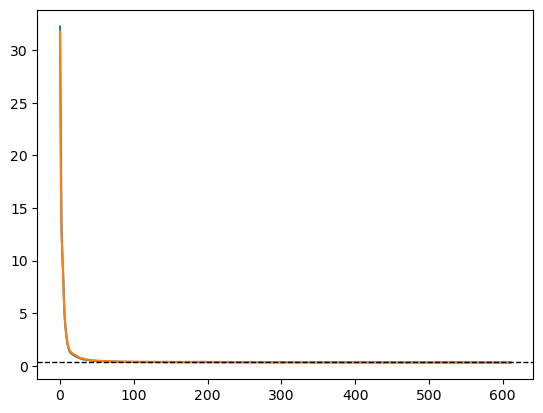

In [22]:
import matplotlib.pyplot as plt 

plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.axhline(y=min(valid_loss_history), color='black', linestyle='--', linewidth=1)
plt.show()

# Load best model

In [23]:
checkpoint = torch.load('./saved_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(epoch, loss.item())

582 0.3269030451774597


# Evaluation

In [24]:
prediction = model(X_test)
loss = criterion(prediction[:,:,0], y_test)

print(f"loss: {loss:.5f}")

loss: 0.56216


In [25]:
prediction = model(X_test)
loss = criterion(prediction[:,-1,0], y_test[:,-1])

print(f"loss: {loss:.5f}")

loss: 0.54242


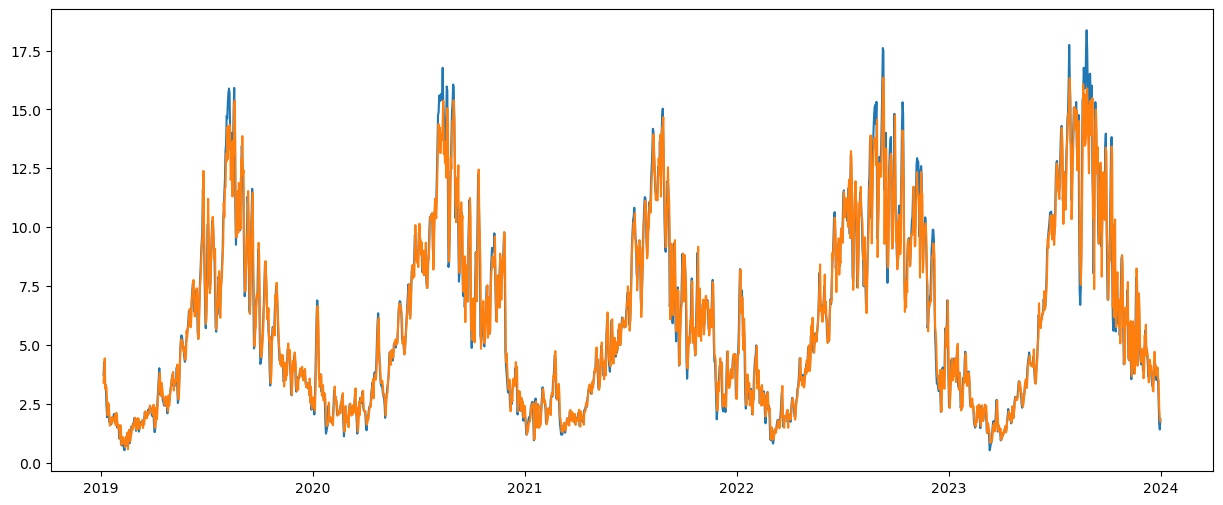

In [26]:
plt.figure(figsize=(15,6))
plt.plot(df_test.iloc[5:]['date'], y_test[:,-1].detach().numpy())
plt.plot(df_test.iloc[5:]['date'], prediction[:,-1,0].detach().numpy())
plt.show()